In [32]:
import os
import numpy as np
import pandas as pd
import cantera as ct
from time import time
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [33]:
# Directories
DIR     = os.getcwd()

Reader Functions

In [34]:
def reader(csv:str):
    data = np.loadtxt(csv, delimiter=',', unpack=True)
    return data

def func_interpolate(xData, yData, kind='linear'):
    return interp1d(xData, yData, kind=kind)

Fix data variation where digitization was performed.

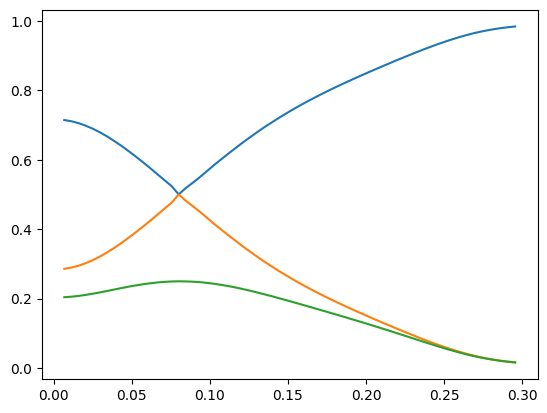

In [ ]:
x2, y2 = reader(os.path.join(DIR, "fig5-35.csv"))
f2 = func_interpolate(x2, y2)

# Data normalization (data was corrupted during realding).
y_max = max(y2)
y2 = y2 - (y_max - 0.25)

df = pd.DataFrame({'r/x': x2, 'variance': y2})
df.to_csv("var_data.csv", index=False)

#plt.plot(0.02 / x2, np.sqrt(y2)*2/4.29368828)
#plt.show()

cc = (1 + np.sqrt(1 - 4 * y2)) / 2

cc2 = (1 - np.sqrt(1 - 4 * y2)) / 2

plt.plot(x2, cc)
plt.plot(x2, cc2)
plt.show()

## Look into stream mixing.

In [42]:
mech = os.path.join(DIR, 'ar22.yaml')
fuel:dict       = {"CH4":1}
oxidizer:dict   = {"O2":0.21 ,"N2":0.79}

gas_a = ct.Solution(mech)
gas_a.TPX = 750, 24 * ct.one_atm, oxidizer
rho_a = gas_a.density

gas_b = ct.Solution(mech)
gas_b.TPX = 750, 24 * ct.one_atm, fuel
rho_b = gas_b.density

In [43]:
res_a = ct.Reservoir(gas_a, name='Air Reservoir')
res_b = ct.Reservoir(gas_b, name='Fuel Reservoir')
downstream = ct.Reservoir(gas_a, name='Outlet Reservoir')

In [56]:
gas_b.TPX = 750, 24 * ct.one_atm, 'O2:0.21, N2:0.79'
mixer = ct.IdealGasReactor(gas_b, name='Mixer')

In [57]:
mfc1 = ct.MassFlowController(res_a, mixer, mdot=rho_a*2.5/0.21, name="Air Inlet")
mfc2 = ct.MassFlowController(res_b, mixer, mdot=rho_b*1.0, name="Fuel Inlet")

In [132]:
outlet = ct.Valve(mixer, downstream, K=10.0, name="Valve")
sim = ct.ReactorNet([mixer])

sim.advance_to_steady_state()
print(mixer.thermo.report())


gas_b.set_mixture_fraction(0.5, 0.3, 0.2, basis='mass')




  gas:

       temperature   750 K
          pressure   2.4318e+06 Pa
           density   10.864 kg/m^3
  mean mol. weight   27.858 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        3.0417e+05        8.4736e+06  J
   internal energy             80325        2.2377e+06  J
           entropy            7265.9        2.0241e+05  J/K
    Gibbs function       -5.1453e+06       -1.4334e+08  J
 heat capacity c_p            1215.9             33873  J/K
 heat capacity c_v            917.47             25559  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
               CH4          0.044625           0.07749           -35.387
                O2           0.22251           0.19373           -24.308
                CO        8.8237e-10        8.7759e-10           -60.311
  

ValueError: Array has incorrect length. Got 1. Expected 23.

In [73]:
gas_a = ct.Solution(mech)
gas_a.TPX = 750, 24 * ct.one_atm, {"CH4":0, "O2":0.21 , "N2":0.79}

print(gas_a.report())

gas_c = ct.Solution(mech)
gas_c.TP = 750, 24 * ct.one_atm
gas_c.set_equivalence_ratio(phi=0.47, fuel=fuel, oxidizer=oxidizer)

print(gas_c.report())


  gas:

       temperature   750 K
          pressure   2.4318e+06 Pa
           density   11.251 kg/m^3
  mean mol. weight   28.851 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        4.7224e+05        1.3624e+07  J
   internal energy         2.561e+05        7.3886e+06  J
           entropy            6930.5        1.9995e+05  J/K
    Gibbs function       -4.7257e+06       -1.3634e+08  J
 heat capacity c_p            1093.8             31558  J/K
 heat capacity c_v            805.65             23244  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.23291              0.21           -24.227
                N2           0.76709              0.79           -21.235
     [  +21 minor]                 0                 0  


  gas:

       t

In [121]:
import numpy as np

# --------------------------------------------------------
# User-defined inputs
# --------------------------------------------------------

U0 = np.arange(40, 181, 10)   # bulk velocities [m/s]
x_positions = np.linspace(0.05, 0.20, 50)   # axial positions in the premixer [m]

# Example mean mass-fraction profile (replace with your actual data)
# Here it simply linearly decays from 1 → 0.1
def mean_mass_fraction(x):
    return 1.0 - 0.9*(x / x_positions[-1])

# --------------------------------------------------------
# User function: mixing timescale
# Insert your existing logic inside this function.
# It must return τ_mix for a given U.
# --------------------------------------------------------

def compute_tau_mix(U, x):
    tau_mix = x/U
    return tau_mix

# --------------------------------------------------------
# Variance models
# --------------------------------------------------------

def bernoulli_variance(c_mean):
    """Bernoulli maximum variance Var = c(1-c)."""
    return c_mean * (1.0 - c_mean)

def exponential_decay_variance(var0, x, U, tau_mix):
    """Var(x) = Var0 * exp( - x / (U * τ_mix) )."""
    L_mix = U * tau_mix
    return var0 * np.exp(-x / L_mix)

# --------------------------------------------------------
# Main loop over bulk velocity
# --------------------------------------------------------

results = {
        "U0":               np.zeros(len(U0)),
        "tau_mix":          np.zeros(len(U0)),
        "x":                np.zeros(len(U0)),
        "c_mean":           np.zeros(len(U0)),
        "var_bernoulli":    np.zeros(len(U0)),
        "var_exp_decay":    np.zeros(len(U0)),
}

for i, U in enumerate(U0):
    results['U0'][i] = U
    results['tau_mix'][i] = compute_tau_mix(U, x_positions[i])
    results['x'][i] = x_positions[i]
    
    mean_profile = np.array([mean_mass_fraction(x) for x in x_positions])
    results['c_mean'][i] = mean_profile[i]

    bern_var = bernoulli_variance(mean_profile)                # local Bernoulli maximum
    results['var_bernoulli'][i] = bern_var[i]
    var0 = 0.25                                                # initial binary scalar variance
    exp_var = exponential_decay_variance(var0, x_positions, U, results['tau_mix'][i])
    results['var_exp_decay'][i] = exp_var[i]
    
    # physical limit: Var ≤ Bernoulli max for given mean
    exp_var_limited = np.minimum(exp_var, bern_var)


df = pd.DataFrame(results)
df

,U0,tau_mix,x,c_mean,var_bernoulli,var_exp_decay
0,40.0,0.001250,0.050000,0.775000,0.174375,0.09197
1,50.0,0.001061,0.053061,0.761224,0.181762,0.09197
2,60.0,0.000935,0.056122,0.747449,0.188769,0.09197
3,70.0,0.000845,0.059184,0.733673,0.195397,0.09197
4,80.0,0.000778,0.062245,0.719898,0.201645,0.09197
5,90.0,0.000726,0.065306,0.706122,0.207514,0.09197
6,100.0,0.000684,0.068367,0.692347,0.213003,0.09197
7,110.0,0.000649,0.071429,0.678571,0.218112,0.09197
8,120.0,0.000621,0.074490,0.664796,0.222842,0.09197
9,130.0,0.000597,0.077551,0.651020,0.227193,0.09197


In [125]:

# --------------------------------------------------------
# Example output
# --------------------------------------------------------
for i, U in enumerate(U0):
    print(f"\nU = {U} m/s")
    print(f"tau_mix = {results['tau_mix'][i]:.4f} s")
    print(f"Initial variance = 0.25")
    print(f"Variance at x = 0.05 m: {results['var_exp_decay'][10]:.4f}")



U = 40 m/s
tau_mix = 0.0013 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 50 m/s
tau_mix = 0.0011 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 60 m/s
tau_mix = 0.0009 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 70 m/s
tau_mix = 0.0008 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 80 m/s
tau_mix = 0.0008 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 90 m/s
tau_mix = 0.0007 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 100 m/s
tau_mix = 0.0007 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 110 m/s
tau_mix = 0.0006 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 120 m/s
tau_mix = 0.0006 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 130 m/s
tau_mix = 0.0006 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 140 m/s
tau_mix = 0.0006 s
Initial variance = 0.25
Variance at x = 0.05 m: 0.0920

U = 150 m/s
tau_mix = 0.0006 s
Initial variance 

In [127]:
import numpy as np
import pandas as pd
import math
import os

# ---------------------------
# User inputs / file
# ---------------------------
csv_path = "/mnt/data/var_data.csv"   # your uploaded file
U0 = np.arange(40, 181, 10)          # [m/s]
var0 = 0.25                          # initial binary variance at injector

# ---------------------------
# Load CSV
# Expecting two columns: x (r/x) and variance
# ---------------------------
df = pd.read_csv(os.path.join(DIR, "fig5-35.csv"))
# normalize column names
df.columns = [c.strip() for c in df.columns]

# try to detect columns
if len(df.columns) < 2:
    raise RuntimeError("CSV must contain at least two columns: x and variance")

x_col = df.columns[0]
var_col = df.columns[1]
x = df[x_col].to_numpy(dtype=float)
obs_var = df[var_col].to_numpy(dtype=float)

# sanity check: variances must be between 0 and 0.25 for Bernoulli
if np.any(obs_var < 0):
    raise ValueError("Observed variance contains negative values.")
# Clip observed variance slightly above 0.25 (numeric tolerance) down to 0.25
obs_var_clipped = np.minimum(obs_var, 0.25)

# ---------------------------
# Back-calculate mean mass fraction from variance (Bernoulli assumption)
# ---------------------------
def mean_from_var_bernoulli(var_array, branch='prefer_high'):
    """
    Solve c(1-c) = var for c.
    branch options:
      - 'prefer_high' : choose the root >= 0.5 (useful when mixture starts fuel-rich)
      - 'prefer_low'  : choose the root <= 0.5
      - 'closest_0_5' : choose the root closest to 0.5
    Returns array of c in [0,1].
    """
    var = np.array(var_array, dtype=float)
    # avoid small negative due to numerics
    var = np.clip(var, 0.0, 0.25)
    disc = 1.0 - 4.0 * var
    # Numerical safety
    disc = np.clip(disc, 0.0, 1.0)
    sqrt_disc = np.sqrt(disc)

    c1 = 0.5 * (1.0 + sqrt_disc)   # >= 0.5
    c2 = 0.5 * (1.0 - sqrt_disc)   # <= 0.5

    if branch == 'prefer_high':
        return c1
    elif branch == 'prefer_low':
        return c2
    elif branch == 'closest_0_5':
        # choose whichever is closer to 0.5 (rarely meaningful but included)
        choose_c1 = np.abs(c1 - 0.5) <= np.abs(c2 - 0.5)
        return np.where(choose_c1, c1, c2)
    else:
        raise ValueError("branch must be one of 'prefer_high','prefer_low','closest_0_5'")

# Choose branch consistent with physics.
# If injection is pure fuel near x=0 (c≈1), use 'prefer_high'
branch_choice = 'prefer_high'
c_from_obs = mean_from_var_bernoulli(obs_var_clipped, branch=branch_choice)

# ---------------------------
# Placeholder: user mixing timescale function
# Replace this body with your actual logic
# ---------------------------
def compute_tau_mix(U):
    """
    Returns tau_mix [s] for a given bulk velocity U [m/s].
    Replace this with your mixing-timescale model.
    Example placeholder: tau ~ 0.01*(40/U)
    """
    return 0.01 * (40.0 / float(U))

# ---------------------------
# Exponential decay model function
# Var_model(x) = var0 * exp(- x / (U * tau_mix))
# ---------------------------
def exp_decay_variance(var0, x_array, U, tau_mix):
    Lmix = float(U) * float(tau_mix)
    # avoid division by zero if tau_mix==0
    if Lmix <= 0.0:
        return np.full_like(x_array, var0)
    return var0 * np.exp(- x_array / Lmix)

# ---------------------------
# Loop over U0 and build results
# ---------------------------
results = []

for U in U0:
    tau = compute_tau_mix(U)
    var_model = exp_decay_variance(var0, x, U, tau)
    # enforce physical upper bound 0.25
    var_model = np.minimum(var_model, 0.25)

    # Optionally: cap model by Bernoulli maximum consistent with the current mean estimate.
    # Since we computed c_from_obs from obs_var, that Bernoulli max equals obs_var (if exact).
    # But in general if you had a guessed mean, you'd compute bern_var = c*(1-c) and cap model.
    bernoulli_max_from_obs = c_from_obs * (1.0 - c_from_obs)  # equals obs_var_clipped (numeric)
    var_model_capped = np.minimum(var_model, bernoulli_max_from_obs)

    # Save arrays (store as list for easy DataFrame assembly)
    for xi, v_obs, v_obs_clip, c_mean, v_mod, v_mod_cap in zip(x, obs_var, obs_var_clipped, c_from_obs, var_model, var_model_capped):
        results.append({
            "U": float(U),
            x_col: float(xi),
            "obs_var": float(v_obs),
            "obs_var_clipped": float(v_obs_clip),
            "c_from_obs": float(c_mean),
            "tau_mix": float(tau),
            "var_model": float(v_mod),
            "var_model_capped_by_bernoulli_of_obs": float(v_mod_cap)
        })

# ---------------------------
# Save results to csv for inspection
# ---------------------------
out_df = pd.DataFrame(results)
out_csv = "variance_link_results.csv"
out_df.to_csv(out_csv, index=False)

# ---------------------------
# Print a concise sample for a representative U
# ---------------------------
sample_U = 100
sample = out_df[out_df["U"] == float(sample_U)].head(10)
print(f"Loaded {len(df)} points from '{csv_path}'.")
print(f"Writing results to '{out_csv}'.")
print(f"\nSample output for U = {sample_U} m/s (first 10 rows):")
print(sample.to_string(index=False))

# End of script


Loaded 68 points from '/mnt/data/var_data.csv'.
Writing results to 'variance_link_results.csv'.

Sample output for U = 100 m/s (first 10 rows):
    U  0.00685761  obs_var  obs_var_clipped  c_from_obs  tau_mix  var_model  var_model_capped_by_bernoulli_of_obs
100.0    0.011436 0.217743         0.217743    0.679602    0.004   0.242954                              0.217743
100.0    0.016015 0.219980         0.219980    0.673263    0.004   0.240188                              0.219980
100.0    0.020593 0.222925         0.222925    0.664545    0.004   0.237455                              0.222925
100.0    0.025172 0.226366         0.226366    0.653734    0.004   0.234752                              0.226366
100.0    0.029751 0.230193         0.230193    0.640737    0.004   0.232081                              0.230193
100.0    0.034329 0.234257         0.234257    0.625471    0.004   0.229439                              0.229439
100.0    0.038908 0.238493         0.238493    0.607271   

In [128]:
import numpy as np

# Create a 1D grid (NumPy array) with 10 elements, initialized to 0
grid_length = 10
my_1d_numpy_grid = np.zeros(grid_length)
print(f"Initial NumPy grid: {my_1d_numpy_grid}")

# Access and modify elements
my_1d_numpy_grid[3] = 5.0
print(f"Modified NumPy grid: {my_1d_numpy_grid}")

# Create a 1D grid with a specific range of values
my_range_grid = np.arange(0, 10, 1) # From 0 to 9, step of 1
print(f"Range NumPy grid: {my_range_grid}")

# Create a 1D grid with evenly spaced values
my_linspace_grid = np.linspace(0, 1, 5) # 5 evenly spaced values between 0 and 1
print(f"Linspace NumPy grid: {my_linspace_grid}")


Initial NumPy grid: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Modified NumPy grid: [0. 0. 0. 5. 0. 0. 0. 0. 0. 0.]
Range NumPy grid: [0 1 2 3 4 5 6 7 8 9]
Linspace NumPy grid: [0.   0.25 0.5  0.75 1.  ]
